In [1]:
from sklearn.linear_model import LinearRegression
import causalpy as cp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# causalpy が提供しているサンプルデータ "did" を読み込む。
# "did" は Difference-in-Differences（差分の差分法）用に用意されたお試しデータで、
# - 単位（企業・地域・個人など）ごとのID
# - 時点（介入前・介入後）の情報
# - 介入群（treated）か対照群（control）かのフラグ
# - アウトカム（売上・テストスコアなど）の指標
# といった列を含むパネルデータになっていることが多い。
# DiD では「介入前後の変化の差」を介入群と対照群で比較することで、
# 時系列トレンドや共通ショックをキャンセルしつつ因果効果を推定する。
data = cp.load_data("did")

# 読み込んだデータの先頭5行を表示して、
# - 列名（unit, time, treated, outcome など）
# - データ型
# - 介入前後・群ごとの構造
# を目視で確認する。DiD のモデルを書き下す前に、
# 「何がアウトカムで何が処置変数か」をここで把握しておくことが重要。
data.head()

,group,t,unit,post_treatment,y
0,0,0.0,0,False,0.897122
1,0,1.0,0,True,1.961214
2,1,0.0,1,False,1.233525
3,1,1.0,1,True,2.752794
4,0,0.0,2,False,1.149207


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.

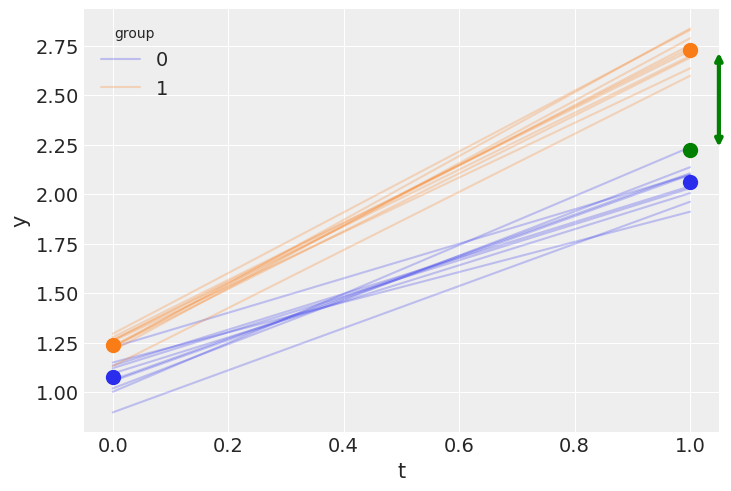

In [4]:
# Difference-in-Differences（差分の差分法：DiD）による因果効果推定の設定
#
# このブロックでは、causalpy の DifferenceInDifferences ラッパを使って
# 「介入群 vs 対照群 × 介入前 vs 介入後」の構造をもつパネルデータから
# 差分の差分推定量（DiD 推定量）を計算しようとしている。
#
# 理論的なゴールは、次のような平均処置効果 δ を推定すること：
#
# $$ \delta
#   = \bigl(\bar{y}_{\text{treated, post}} - \bar{y}_{\text{treated, pre}}\bigr)
#   - \bigl(\bar{y}_{\text{control, post}} - \bar{y}_{\text{control, pre}}\bigr) $$
#
# これは「介入後に treated だけ余分に増えた（減った）分」を抽出する量で、
# 適切な仮定の下で介入の因果効果として解釈される。

result = cp.skl_experiments.DifferenceInDifferences(
    data,
    # ------------------------------------------------------------
    # モデルの式（R 風 formula）
    # ------------------------------------------------------------
    #   y ~ 1 + group*post_treatment
    #
    # ・y
    #   解析対象となるアウトカム（従属変数）。
    #   DiD では「介入の前後でどう変わったか」を見たい指標（売上、テストスコアなど）が入る。
    #
    # ・1
    #   切片（intercept）。「全体のベースライン水準」を表す。
    #
    # ・group*post_treatment
    #   R 記法で「main effect + interaction」を意味する演算子。
    #   実際には
    #       group + post_treatment + group:post_treatment
    #   に展開される。
    #
    #   - group:
    #       treated グループか control グループかの差（0/1）を表すダミー。
    #       介入前にすでに存在しているレベル差（元々の水準の違い）を捕まえる項。
    #
    #   - post_treatment:
    #       介入前（0）か介入後（1）かを表す時間ダミー。
    #       両グループに共通する時間トレンド（景気・制度変更など）を表す項。
    #
    #   - group:post_treatment（交互作用項）:
    #       DiD 推定量のコアとなる項。
    #       「介入後に treated グループだけ余分に変化した分」を表し、
    #       その係数が平均処置効果（DiD 推定された因果効果）に対応する。
    #
    # 線形モデルの形に書き直すと
    #
    # $$ y_{it}
    #    = \alpha
    #    + \beta \cdot \text{group}_i
    #    + \gamma \cdot \text{post}_t
    #    + \delta \cdot (\text{group}_i \times \text{post}_t)
    #    + \varepsilon_{it} $$
    #
    # となり、このうち δ が欲しい「介入効果」を表す。
    formula="y ~ 1 + group*post_treatment",
    # ------------------------------------------------------------
    # 時間変数とグループ変数の指定
    # ------------------------------------------------------------
    # time_variable_name:
    #   「いつ観測されたか」を表す列名。
    #   ここでは 't' が時点インデックス（pre / post あるいは 0,1,2,... のような時間）として使われる。
    #   DifferenceInDifferences クラスはこれを使って「介入前後」を認識し、
    #   介入効果の前後比較を行う。
    time_variable_name="t",
    # group_variable_name:
    #   「どの観測が treated グループで、どれが control グループか」を表す列名。
    #   ここでは 'group' が 0/1 のダミー変数になっている想定。
    group_variable_name="group",
    # treated / untreated:
    #   group 列の値のうち、どれを介入群（treated）、
    #   どれを対照群（untreated）とみなすかの指定。
    #   ここでは 1 が treated、0 が untreated。
    treated=1,
    untreated=0,
    # ------------------------------------------------------------
    # 推定に用いるモデル（基礎回帰モデル）
    # ------------------------------------------------------------
    # model:
    #   与えられた formula に基づいて回帰を行う sklearn モデル。
    #   ここでは LinearRegression（最小二乗法）を使用している。
    #
    #   理論的には、上で書いた線形 DiD モデル
    #
    #   $$ y_{it}
    #      = \alpha
    #      + \beta \cdot \text{group}_i
    #      + \gamma \cdot \text{post}_t
    #      + \delta \cdot (\text{group}_i \times \text{post}_t)
    #      + \varepsilon_{it} $$
    #
    #   のパラメータ（α, β, γ, δ）を OLS で推定していることに相当する。
    #   このうち δ の推定値が Difference-in-Differences による因果効果推定量となる。
    model=LinearRegression(),
)

# ------------------------------------------------------------
# 結果の可視化
# ------------------------------------------------------------
# result.plot():
#   DiD の典型的な図（time を横軸、平均アウトカムを縦軸にとり、
#   treated / control の 2 系列の線グラフを描く）をプロットする。
#
#   ・介入前の傾き（トレンド）が treated / control でほぼ平行なら、
#     並行トレンド仮定（Parallel Trends Assumption）が
#     視覚的にはおおむね妥当と言える。
#
# 並行トレンド仮定は、形式的には
#
# $$ \mathbb{E}[Y_{it}(0) - Y_{jt}(0)] = \text{const.} \quad (\forall t) $$
#
# のように表され、
# 「介入がなかった世界では treated と control のアウトカムの差は
#  時間によらず一定だったはず」という仮定である。
# この仮定の下で、交互作用項の係数 δ を「介入の因果効果」として解釈できる。
fig, ax = result.plot()  # 分析結果のプロット（DiD グラフ）

# ☆ 補足（今回出ているエラーについて）:
#   実行時に
#     ValueError: setting an array element with a sequence ...
#   というエラーが出ているのは、
#   causalpy 側の plot 実装が内部で扱っている配列の shape（1 次元/2 次元）が
#   NumPy の期待と噛み合っておらず、
#   「長さの揃っていないシーケンスを 1 つの配列要素に詰めようとしている」
#   ことが原因と考えられる。
#
#   - 特に、sklearn の LinearRegression が返す予測値の shape（(n_samples, 1) か (n_samples,) か）
#     と causalpy の想定 shape のズレが原因になりやすい。
#   - 図そのものは「DiD の平均パターンをプロットするだけ」なので、
#     必要であれば自前で group×time ごとの平均 y を集計し、
#     matplotlib で 2 本の線を描くことで代替できる。
#
#   いずれにせよ、理論的な位置づけとしては上記コメントのとおりであり、
#   エラーは「可視化用ラッパの shape まわりの実装依存の問題」であって、
#   DiD の統計モデルそのものが破綻しているわけではない点に注意されたい。